## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import requests

### Exploring Dataset

https://data.cityofnewyork.us/Public-Safety/Incidents-Responded-to-by-Fire-Companies/tm6d-hbzd

In [2]:
df=pd.read_csv("/home/jak/Desktop/Incidents_Responded_to_by_Fire_Companies.csv")

/home/jak/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,IM_INCIDENT_KEY,FIRE_BOX,INCIDENT_TYPE_DESC,INCIDENT_DATE_TIME,ARRIVAL_DATE_TIME,UNITS_ONSCENE,LAST_UNIT_CLEARED_DATE_TIME,HIGHEST_LEVEL_DESC,TOTAL_INCIDENT_DURATION,ACTION_TAKEN1_DESC,...,ZIP_CODE,BOROUGH_DESC,FLOOR,CO_DETECTOR_PRESENT_DESC,FIRE_ORIGIN_BELOW_GRADE_FLAG,STORY_FIRE_ORIGIN_COUNT,FIRE_SPREAD_DESC,DETECTOR_PRESENCE_DESC,AES_PRESENCE_DESC,STANDPIPE_SYS_PRESENT_FLAG
0,63476768,2928.0,"746 - Carbon monoxide detector activation, no CO",06/30/2018 11:55:29 PM,07/01/2018 12:00:32 AM,2.0,07/01/2018 12:22:57 AM,11 - First Alarm,1648.0,"42 - HazMat detection, monitoring, sampling, &...",...,10453.0,2 - Bronx,1,Yes,NaN,NaN,NaN,NaN,NaN,NaN
1,63476763,1021.0,"300 - Rescue, EMS incident, other",06/30/2018 11:54:44 PM,06/30/2018 11:58:59 PM,1.0,07/01/2018 12:09:29 AM,11 - First Alarm,885.0,"00 - Action taken, other",...,11203.0,4 - Brooklyn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,63476761,2745.0,"651 - Smoke scare, odor of smoke",06/30/2018 11:54:13 PM,06/30/2018 11:58:29 PM,3.0,07/01/2018 12:07:50 AM,11 - First Alarm,817.0,"00 - Action taken, other",...,10456.0,2 - Bronx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,63476762,2135.0,"117 - Commercial Compactor fire, confined to r...",06/30/2018 11:54:08 PM,06/30/2018 11:58:53 PM,5.0,07/01/2018 12:19:16 AM,11 - First Alarm,1508.0,11 - Extinguishment by fire service personnel,...,10454.0,2 - Bronx,basement,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,63476759,1877.0,"710 - Malicious, mischievous false call, other",06/30/2018 11:53:33 PM,06/30/2018 11:56:50 PM,1.0,06/30/2018 11:57:11 PM,11 - First Alarm,218.0,"00 - Action taken, other",...,11208.0,4 - Brooklyn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Extracting Relevant Data
For our analysis of places in New York with high fire calls we require to extract 
* **ZIP_CODE** *(Zip code of the place)*
* **TOTAL_INCIDENT_DURATION** *(Time period for which the fire was not extinguisghed)*
* **INCIDENT_TYPE_DESC** *(Type of incident)* 
* **HIGHEST_LEVEL_DESC**
* **ACTION_TAKEN1_DESC** *(Action taken by the authority)*

In [4]:
data=df.loc[:,["ZIP_CODE","TOTAL_INCIDENT_DURATION","INCIDENT_TYPE_DESC","HIGHEST_LEVEL_DESC","ACTION_TAKEN1_DESC"]]
data.head()

,ZIP_CODE,TOTAL_INCIDENT_DURATION,INCIDENT_TYPE_DESC,HIGHEST_LEVEL_DESC,ACTION_TAKEN1_DESC
0,10453.0,1648.0,"746 - Carbon monoxide detector activation, no CO",11 - First Alarm,"42 - HazMat detection, monitoring, sampling, &..."
1,11203.0,885.0,"300 - Rescue, EMS incident, other",11 - First Alarm,"00 - Action taken, other"
2,10456.0,817.0,"651 - Smoke scare, odor of smoke",11 - First Alarm,"00 - Action taken, other"
3,10454.0,1508.0,"117 - Commercial Compactor fire, confined to r...",11 - First Alarm,11 - Extinguishment by fire service personnel
4,11208.0,218.0,"710 - Malicious, mischievous false call, other",11 - First Alarm,"00 - Action taken, other"


## Feature Engineering Dataset
This includes
* Dropping  incomplete data
* Normalisation
* Grouping the data by ZIP CODE

In [5]:
data = data.dropna(how='any',axis=0) 
data["ZIP_CODE"]= data["ZIP_CODE"].astype(int)
data["TOTAL_INCIDENT_DURATION"]= data["TOTAL_INCIDENT_DURATION"].astype(int)/max(data["TOTAL_INCIDENT_DURATION"].astype(int))

In [6]:
data11 = pd.get_dummies(data["INCIDENT_TYPE_DESC"], prefix="", prefix_sep="")
data22 = pd.get_dummies(data["HIGHEST_LEVEL_DESC"], prefix="", prefix_sep="")
data33 = pd.get_dummies(data["ACTION_TAKEN1_DESC"], prefix="", prefix_sep="")
dff=pd.concat([data11, data22,data33,data["ZIP_CODE"],data["TOTAL_INCIDENT_DURATION"]], axis=1)
dff.head()

,"100 - Fire, other",111 - Building fire,112 - Fires in structure other than in a building,"113 - Cooking fire, confined to container","114 - Chimney or flue fire, confined to chimney or flue","115 - Incinerator overload or malfunction, fire confined","116 - Fuel burner/boiler malfunction, fire confined","117 - Commercial Compactor fire, confined to rubbish","118 - Trash or rubbish fire, contained","120 - Fire in mobile prop. used as a fixed struc., other",...,82 - Notify other agencies.,83 - Provide information to public or media,84 - Refer to proper authority,85 - Enforce codes,86 - Investigate,87 - Investigate fire out on arrival,91 - Fill-in or moveup,93 - Cancelled en route,ZIP_CODE,TOTAL_INCIDENT_DURATION
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10453,0.000267
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11203,0.000143
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10456,0.000132
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,10454,0.000244
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11208,0.000035


In [7]:
dff1=dff.groupby(['ZIP_CODE']).sum()
dff1.head()

,"100 - Fire, other",111 - Building fire,112 - Fires in structure other than in a building,"113 - Cooking fire, confined to container","114 - Chimney or flue fire, confined to chimney or flue","115 - Incinerator overload or malfunction, fire confined","116 - Fuel burner/boiler malfunction, fire confined","117 - Commercial Compactor fire, confined to rubbish","118 - Trash or rubbish fire, contained","120 - Fire in mobile prop. used as a fixed struc., other",...,812 - Assigned sector commander,82 - Notify other agencies.,83 - Provide information to public or media,84 - Refer to proper authority,85 - Enforce codes,86 - Investigate,87 - Investigate fire out on arrival,91 - Fill-in or moveup,93 - Cancelled en route,TOTAL_INCIDENT_DURATION
ZIP_CODE,,,,,,,,,,,,,,,,,,,,,
10001,25.0,26.0,21.0,112.0,2.0,0.0,30.0,10.0,55.0,0.0,...,1.0,106.0,0.0,2.0,0.0,2006.0,3.0,2.0,84.0,2.185813
10002,23.0,47.0,27.0,440.0,1.0,4.0,33.0,41.0,52.0,0.0,...,0.0,189.0,1.0,7.0,1.0,1756.0,1.0,0.0,128.0,3.255216
10003,15.0,31.0,23.0,239.0,0.0,0.0,54.0,5.0,62.0,0.0,...,0.0,147.0,0.0,3.0,0.0,2229.0,1.0,0.0,131.0,2.008616
10004,9.0,5.0,11.0,28.0,0.0,0.0,0.0,1.0,11.0,0.0,...,0.0,24.0,0.0,0.0,0.0,562.0,2.0,0.0,18.0,0.441220
10005,8.0,5.0,8.0,36.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,20.0,0.0,0.0,0.0,445.0,3.0,0.0,33.0,0.341890


## Applying K Means for clustering the Data

In [8]:
from sklearn.cluster import KMeans
kclusters = 3

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dff1)
kmeans.labels_

array([1, 2, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1,
       0, 1, 1, 2, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 1,
       1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1,
       2, 0, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 2], dtype=int32)

**Each Category shows the proness to fire.**
* *Category-0 is most prone to fire cases*
* *Category-2 is least prone to fire cases*

In [9]:
dff1.insert(0, 'Cluster Labels', kmeans.labels_)
dff1.head()

,Cluster Labels,"100 - Fire, other",111 - Building fire,112 - Fires in structure other than in a building,"113 - Cooking fire, confined to container","114 - Chimney or flue fire, confined to chimney or flue","115 - Incinerator overload or malfunction, fire confined","116 - Fuel burner/boiler malfunction, fire confined","117 - Commercial Compactor fire, confined to rubbish","118 - Trash or rubbish fire, contained",...,812 - Assigned sector commander,82 - Notify other agencies.,83 - Provide information to public or media,84 - Refer to proper authority,85 - Enforce codes,86 - Investigate,87 - Investigate fire out on arrival,91 - Fill-in or moveup,93 - Cancelled en route,TOTAL_INCIDENT_DURATION
ZIP_CODE,,,,,,,,,,,,,,,,,,,,,
10001,1,25.0,26.0,21.0,112.0,2.0,0.0,30.0,10.0,55.0,...,1.0,106.0,0.0,2.0,0.0,2006.0,3.0,2.0,84.0,2.185813
10002,2,23.0,47.0,27.0,440.0,1.0,4.0,33.0,41.0,52.0,...,0.0,189.0,1.0,7.0,1.0,1756.0,1.0,0.0,128.0,3.255216
10003,1,15.0,31.0,23.0,239.0,0.0,0.0,54.0,5.0,62.0,...,0.0,147.0,0.0,3.0,0.0,2229.0,1.0,0.0,131.0,2.008616
10004,0,9.0,5.0,11.0,28.0,0.0,0.0,0.0,1.0,11.0,...,0.0,24.0,0.0,0.0,0.0,562.0,2.0,0.0,18.0,0.441220
10005,0,8.0,5.0,8.0,36.0,0.0,0.0,0.0,0.0,5.0,...,0.0,20.0,0.0,0.0,0.0,445.0,3.0,0.0,33.0,0.341890


## Using dataset to extract coordinates of places

In [10]:
zipcode=pd.read_csv("/home/jak/Desktop/Zip_Codes_Government_Data.csv")
zipcode.rename({'ZIP': 'ZIP_CODE'}, axis='columns', inplace=True)
data_df = pd.merge(dff1,zipcode,left_index=True,right_on="ZIP_CODE")
data_df.head()

,Cluster Labels,"100 - Fire, other",111 - Building fire,112 - Fires in structure other than in a building,"113 - Cooking fire, confined to container","114 - Chimney or flue fire, confined to chimney or flue","115 - Incinerator overload or malfunction, fire confined","116 - Fuel burner/boiler malfunction, fire confined","117 - Commercial Compactor fire, confined to rubbish","118 - Trash or rubbish fire, contained",...,84 - Refer to proper authority,85 - Enforce codes,86 - Investigate,87 - Investigate fire out on arrival,91 - Fill-in or moveup,93 - Cancelled en route,TOTAL_INCIDENT_DURATION,ZIP_CODE,LAT,LNG
2569,1,25.0,26.0,21.0,112.0,2.0,0.0,30.0,10.0,55.0,...,2.0,0.0,2006.0,3.0,2.0,84.0,2.185813,10001,40.750633,-73.997177
2570,2,23.0,47.0,27.0,440.0,1.0,4.0,33.0,41.0,52.0,...,7.0,1.0,1756.0,1.0,0.0,128.0,3.255216,10002,40.715775,-73.986212
2571,1,15.0,31.0,23.0,239.0,0.0,0.0,54.0,5.0,62.0,...,3.0,0.0,2229.0,1.0,0.0,131.0,2.008616,10003,40.731829,-73.989181
2572,0,9.0,5.0,11.0,28.0,0.0,0.0,0.0,1.0,11.0,...,0.0,0.0,562.0,2.0,0.0,18.0,0.441220,10004,40.688630,-74.018244
2573,0,8.0,5.0,8.0,36.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,445.0,3.0,0.0,33.0,0.341890,10005,40.706027,-74.008835


## Maping Data using Folium

In [11]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
map_clusters = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(data_df['LAT'], data_df['LNG'], data_df['Cluster Labels']):
    label = folium.Popup( ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

/bin/sh: 1: conda: not found


## Client details for using FOURSQUARE API

In [12]:
CLIENT_ID = '2JHMQCZSBYWTAZBYCXN4HAXCJ4MHJ0CRJ3LT3KAJSHAXOGGW' # your Foursquare ID
CLIENT_SECRET = 'EHFK1W4Q5L53EDSSBVACC3ZTN3AQSR13B5HIEAX5WRNEAVAC' # your Foursquare Secret
VERSION = '20190703' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 2JHMQCZSBYWTAZBYCXN4HAXCJ4MHJ0CRJ3LT3KAJSHAXOGGW
CLIENT_SECRET:EHFK1W4Q5L53EDSSBVACC3ZTN3AQSR13B5HIEAX5WRNEAVAC


## Formimg a Dataset of all the food joints in a given area

This is done to count the number of food joints and observe if more fire cases are related to it.

In [13]:
def getNearbyVenues(cluster,zipcode,latitudes, longitudes, radius=500):
    limit=200
    venues_list=[]
    for lat, lng in zip( latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&categoryId=4d4b7105d754a06374d81259&client_id={}&client_secret={}&v={}&ll={},{}&LIMIT={}&radius={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            limit,
            radius
            )  
        # make the GET request
        results = len(requests.get(url).json()["response"]["venues"])
        
        # return only relevant information for each nearby venue
        venues_list.append(results)
    data={
        "ZIPCODE":zipcode,
        "Number_of_Food_Joints":venues_list,
        "Cluster Labels":cluster
    }
    nearby_venues = pd.DataFrame(data)

    print("Finished!")
    
    return(nearby_venues)

In [14]:
nyc_venues = getNearbyVenues(cluster=data_df['Cluster Labels'],
                                zipcode=data_df['ZIP_CODE'],
                                latitudes=data_df['LAT'],
                                 longitudes=data_df['LNG'],
                                 radius = 500
                                )
nyc_venues.head()

Finished!


,ZIPCODE,Number_of_Food_Joints,Cluster Labels
2569,10001,30,1
2570,10002,30,2
2571,10003,30,1
2572,10004,25,0
2573,10005,30,0


## Final Dataset

In [15]:
nyc_venues=nyc_venues.drop(["ZIPCODE"],1)
new=nyc_venues.groupby(['Cluster Labels']).sum()
new.reset_index(inplace=True)
new.head()

,Cluster Labels,Number_of_Food_Joints
0,0,2050
1,1,2033
2,2,518


## Plotting the Data

['Category 0', 'Category 1', 'Category 2']


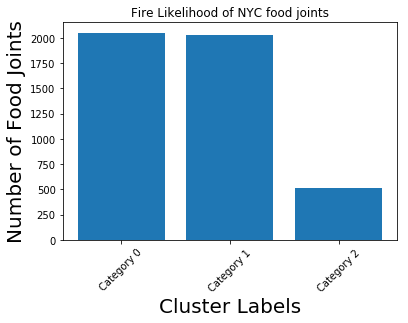

In [17]:
import matplotlib.pyplot as plt
p=[]
for i in new["Cluster Labels"]:
    p.append("Category "+str(i))
print(p)
plt.bar(new["Cluster Labels"],new["Number_of_Food_Joints"])
plt.xlabel('Cluster Labels', fontsize=20)
plt.ylabel('Number of Food Joints', fontsize=20)
plt.xticks(new["Cluster Labels"],p,fontsize=10, rotation=45)
plt.title('Fire Likelihood of NYC food joints')
plt.show()

## RESULT
As from the dataset most fire breakouts were in the region with high number of food joints. Fire breakouts were less in the regions with less food joints.

## Discussion
we conclude that most fire breakouts in NYC are due to food joints. This include kitchen fires or others due to high density of customers.  Hence fire department must express its concern for the issue and work for safety of people in the region. People must be aware about first aids and emergency equipment must be present in the food joint premises. This will help tourist and residents for a better lifestyle.


## Conclusion
Hence, we have concluded that most fire breakouts in NYC are due to food joints. This include kitchen fires or others due to high density of customers.
